In [ ]:
# === 1. MOUNT GOOGLE DRIVE ===
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === 2. SET DATASET PATHS ===
data_dir = '/content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/Data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [ ]:
# === 3. IMPORT LIBRARIES ===
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     Concatenate, Flatten, Dense, Dropout, ReLU)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from PIL import Image
import json
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# === 4. IMAGE SIZE AND BATCH ===
IMG_SIZE = 224
BATCH_SIZE = 32


In [ ]:
# === 5. DATA AUGMENTATION FOR TRAINING ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.10,
    zoom_range=0.10,
    fill_mode='nearest',
    validation_split=0.1  # 10% for validation
)


In [ ]:
# === 6. DATA GENERATORS ===
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4649 images belonging to 3 classes.
Found 515 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
# === 7. DILATED CONVOLUTIONAL BLOCK ===
def PDr_conv_block(x, filters, dilation_rate):
    x = Conv2D(filters, (3, 3), padding='same', dilation_rate=dilation_rate)(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), padding='same', dilation_rate=dilation_rate)(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [ ]:
# === 8. BUILD PDCOVIDNET MODEL ===
def build_pdcovidnet(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Parallel branch with dilation rate 1
    branch1 = PDr_conv_block(inputs, 64, 1)
    branch1 = PDr_conv_block(branch1, 128, 1)
    branch1 = PDr_conv_block(branch1, 256, 1)
    branch1 = PDr_conv_block(branch1, 512, 1)
    branch1 = PDr_conv_block(branch1, 512, 1)

    # Parallel branch with dilation rate 2
    branch2 = PDr_conv_block(inputs, 64, 2)
    branch2 = PDr_conv_block(branch2, 128, 2)
    branch2 = PDr_conv_block(branch2, 256, 2)
    branch2 = PDr_conv_block(branch2, 512, 2)
    branch2 = PDr_conv_block(branch2, 512, 2)

    # Merge and final layers
    merged = Concatenate()([branch1, branch2])
    merged = Conv2D(512, (3, 3), padding='same')(merged)
    merged = ReLU()(merged)
    x = Flatten()(merged)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
# === 9. COMPILE MODEL ===
model = build_pdcovidnet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# === 10. TRAIN MODEL ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/best_model_2.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6463 - loss: 0.8629 
Epoch 1: val_accuracy improved from -inf to 0.66214, saving model to /content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/best_model_2.h5


146/146 ━━━━━━━━━━━━━━━━━━━━ 3363s 23s/step - accuracy: 0.6464 - loss: 0.8623 - val_accuracy: 0.6621 - val_loss: 0.7584
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.6646 - loss: 0.6460
Epoch 2: val_accuracy improved from 0.66214 to 0.76699, saving model to /content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/best_model_2.h5


146/146 ━━━━━━━━━━━━━━━━━━━━ 133s 891ms/step - accuracy: 0.6648 - loss: 0.6457 - val_accuracy: 0.7670 - val_loss: 0.7173
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.8263 - loss: 0.4242
Epoch 3: val_accuracy improved from 0.76699 to 0.82524, saving model to /content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/best_model_2.h5


146/146 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8264 - loss: 0.4240 - val_accuracy: 0.8252 - val_loss: 0.5684
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.8678 - loss: 0.3321
Epoch 4: val_accuracy improved from 0.82524 to 0.82718, saving model to /content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/best_model_2.h5


146/146 ━━━━━━━━━━━━━━━━━━━━ 145s 983ms/step - accuracy: 0.8679 - loss: 0.3320 - val_accuracy: 0.8272 - val_loss: 0.4762
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.8874 - loss: 0.2801
Epoch 5: val_accuracy improved from 0.82718 to 0.84660, saving model to /content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/best_model_2.h5


146/146 ━━━━━━━━━━━━━━━━━━━━ 142s 969ms/step - accuracy: 0.8875 - loss: 0.2800 - val_accuracy: 0.8466 - val_loss: 0.7100
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9050 - loss: 0.2595
Epoch 6: val_accuracy improved from 0.84660 to 0.86602, saving model to /content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/best_model_2.h5


146/146 ━━━━━━━━━━━━━━━━━━━━ 144s 981ms/step - accuracy: 0.9051 - loss: 0.2594 - val_accuracy: 0.8660 - val_loss: 0.4514
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9193 - loss: 0.2361
Epoch 7: val_accuracy did not improve from 0.86602
146/146 ━━━━━━━━━━━━━━━━━━━━ 137s 932ms/step - accuracy: 0.9193 - loss: 0.2361 - val_accuracy: 0.8447 - val_loss: 0.5207
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.9279 - loss: 0.1923
Epoch 8: val_accuracy improved from 0.86602 to 0.89126, saving model to /content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/best_model_2.h5


146/146 ━━━━━━━━━━━━━━━━━━━━ 130s 887ms/step - accuracy: 0.9279 - loss: 0.1924 - val_accuracy: 0.8913 - val_loss: 0.3430
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9267 - loss: 0.2061
Epoch 9: val_accuracy did not improve from 0.89126
146/146 ━━━━━━━━━━━━━━━━━━━━ 137s 931ms/step - accuracy: 0.9267 - loss: 0.2061 - val_accuracy: 0.8757 - val_loss: 0.3242
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9371 - loss: 0.1794
Epoch 10: val_accuracy did not improve from 0.89126
146/146 ━━━━━━━━━━━━━━━━━━━━ 123s 840ms/step - accuracy: 0.9371 - loss: 0.1794 - val_accuracy: 0.8816 - val_loss: 0.4568
Epoch 11/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.9460 - loss: 0.1659
Epoch 11: val_accuracy did not improve from 0.89126
146/146 ━━━━━━━━━━━━━━━━━━━━ 123s 839ms/step - accuracy: 0.9460 - loss: 0.1659 - val_accuracy: 0.8796 - val_loss: 0.3835
Epoch 12/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9459 - loss: 0.1508
Epoch 

146/146 ━━━━━━━━━━━━━━━━━━━━ 131s 896ms/step - accuracy: 0.9387 - loss: 0.1716 - val_accuracy: 0.9107 - val_loss: 0.2865
Epoch 14/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.9467 - loss: 0.1443
Epoch 14: val_accuracy did not improve from 0.91068
146/146 ━━━━━━━━━━━━━━━━━━━━ 136s 929ms/step - accuracy: 0.9466 - loss: 0.1443 - val_accuracy: 0.9010 - val_loss: 0.3075
Epoch 15/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9500 - loss: 0.1449
Epoch 15: val_accuracy did not improve from 0.91068
146/146 ━━━━━━━━━━━━━━━━━━━━ 123s 838ms/step - accuracy: 0.9500 - loss: 0.1450 - val_accuracy: 0.8913 - val_loss: 0.4016
Epoch 16/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9473 - loss: 0.1414
Epoch 16: val_accuracy did not improve from 0.91068
146/146 ━━━━━━━━━━━━━━━━━━━━ 123s 840ms/step - accuracy: 0.9473 - loss: 0.1414 - val_accuracy: 0.8971 - val_loss: 0.2802
Epoch 17/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9476 - loss: 0.1396
Epoc

In [ ]:
# === 11. EVALUATE ON VALIDATION AND TEST SET ===
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 618ms/step - accuracy: 0.9201 - loss: 0.2743
41/41 ━━━━━━━━━━━━━━━━━━━━ 875s 22s/step - accuracy: 0.9305 - loss: 0.1803
Validation Accuracy: 91.46%
Test Accuracy: 93.79%


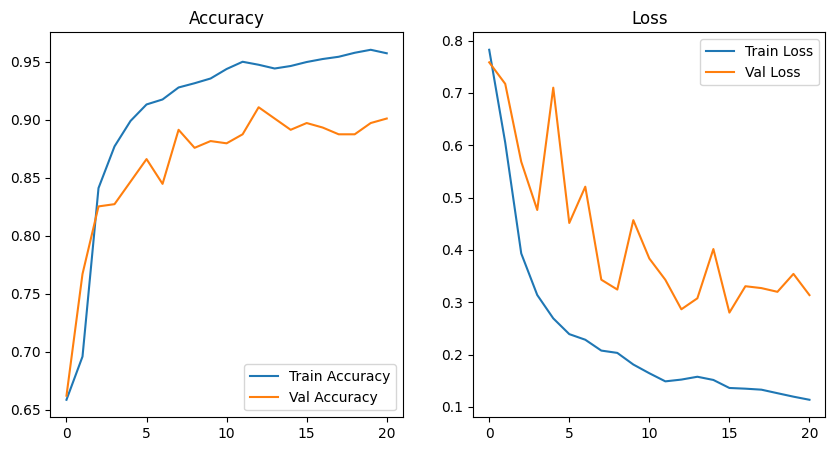

In [ ]:
# === 12. PLOT TRAINING HISTORY ===
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()


In [ ]:
# === 13. SAVE MODEL AND LABELS ===
model.save('/content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/PDCOVIDNet_model_2.h5')
with open('/content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/PDCOVIDNet_class_indices_2.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


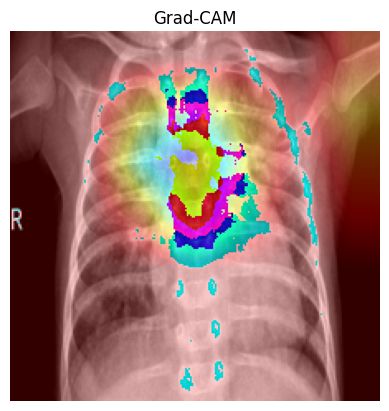

In [ ]:
# === 14. GRAD-CAM VISUALIZATION ===
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


    # Example usage
img_path = '/content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/Data/train/PNEUMONIA/PNEUMONIA(3417).jpg'  # update with your image
img = Image.open(img_path).convert('RGB').resize((224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name='conv2d_20')  # change if needed
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + np.uint8(img)

plt.imshow(superimposed_img.astype(np.uint8))
plt.title("Grad-CAM")
plt.axis('off')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step
Classification Report (Test):

              precision    recall  f1-score   support

     COVID19       0.99      0.91      0.95       116
      NORMAL       0.85      0.91      0.88       317
   PNEUMONIA       0.97      0.95      0.96       855

    accuracy                           0.94      1288
   macro avg       0.94      0.92      0.93      1288
weighted avg       0.94      0.94      0.94      1288



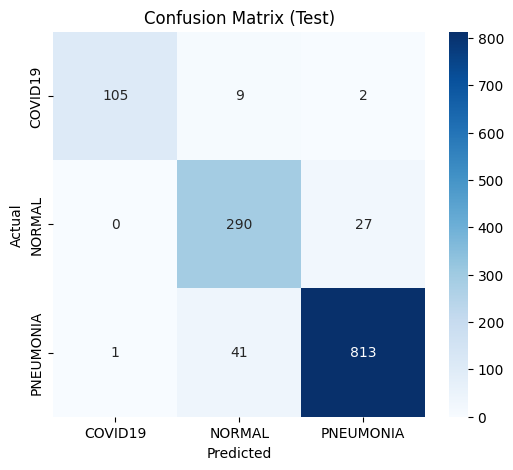

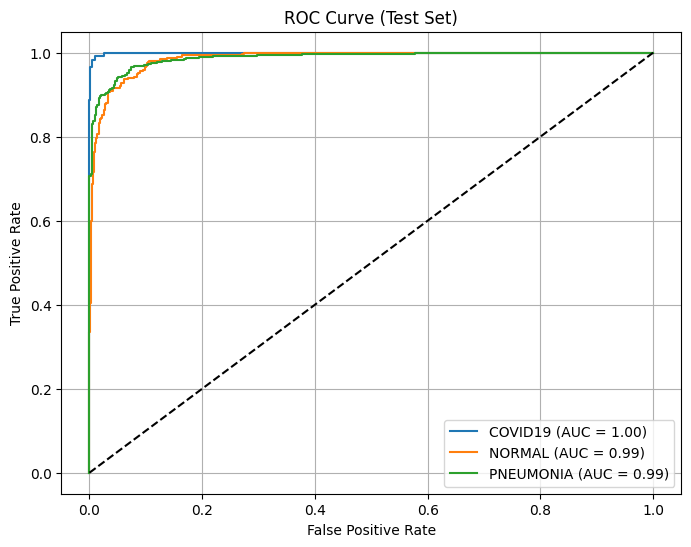

In [ ]:
# === 15. CONFUSION MATRIX, F1, ROC-AUC FOR TEST SET ===
y_true = test_generator.classes
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
class_names = list(test_generator.class_indices.keys())

print("Classification Report (Test):\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, label in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

Saving COVID19(3).jpg to COVID19(3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Predicted Class: COVID19
Confidence: 98.58%


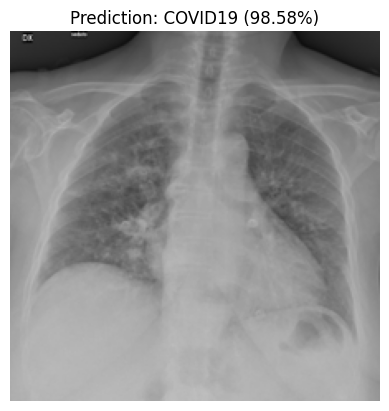

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


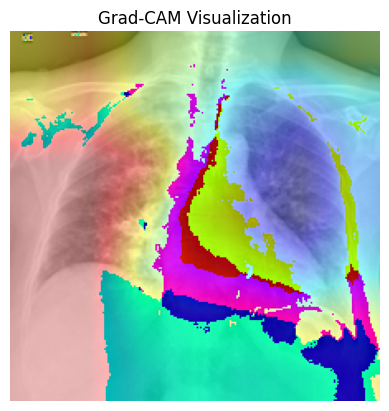

In [ ]:
# === 16. UPLOAD AN IMAGE AND MAKE A PREDICTION ===

from google.colab import files
from tensorflow.keras.models import load_model

# Load trained model and class labels
model = load_model('/content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/PDCOVIDNet_model_2.h5')

with open('/content/drive/MyDrive/Colab Notebooks/PDCOVIDNet_Dataset/PDCOVIDNet_class_indices_2.json', 'r') as f:
    class_indices = json.load(f)
    class_labels = {v: k for k, v in class_indices.items()}

# Upload image
uploaded = files.upload()

for file_name in uploaded.keys():
    # Load and preprocess image
    img_path = file_name
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100

    print(f"\nPredicted Class: {class_labels[predicted_class]}")
    print(f"Confidence: {confidence:.2f}%")

    # Display image
    plt.imshow(img)
    plt.title(f"Prediction: {class_labels[predicted_class]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    # === Optional: Grad-CAM Visualization ===
    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name='conv2d_20')  # update if needed
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + np.uint8(img)

    plt.imshow(superimposed_img.astype(np.uint8))
    plt.title("Grad-CAM Visualization")
    plt.axis('off')
    plt.show()
